In [2]:
# =========================
# chargement de donnees
# =========================
import os
from zipfile import ZipFile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from google.colab import drive

# 1) Monter Google Drive
drive.mount('/content/drive')

# 2) Chemin du zip
zip_path = "/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_dataset.zip"
extract_path = "/content/COVID-19_Radiography_Dataset"

# 3) Dézipper si besoin
if not os.path.exists(extract_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")



Mounted at /content/drive


In [3]:
# =========================
# Réorganisation (2 classes)
# =========================
import shutil

prepared_data_dir = "/content/covid_data_prepared"
os.makedirs(prepared_data_dir, exist_ok=True)


classes = ["COVID", "Normal"]

def find_src_dir(cls):
    
    candidates = [
        os.path.join("/content/COVID-19_Radiography_Dataset", cls, "images"),
        os.path.join("/content/COVID-19_Radiography_Dataset", cls),
        os.path.join("/content", cls, "images"),
        os.path.join("/content", cls),
    ]
    for p in candidates:
        if os.path.isdir(p):
            return p
    raise FileNotFoundError(f"Dossier images introuvable pour la classe '{cls}'.")

copied_counts = {}
for cls in classes:
    src_img_dir = find_src_dir(cls)
    dst_class_dir = os.path.join(prepared_data_dir, cls.replace(" ", "_"))
    os.makedirs(dst_class_dir, exist_ok=True)

    
    exts = {".png", ".jpg", ".jpeg", ".bmp"}
    n = 0
    for filename in os.listdir(src_img_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            shutil.copy(os.path.join(src_img_dir, filename),
                        os.path.join(dst_class_dir, filename))
            n += 1
    copied_counts[cls] = n

print("✅ Réorganisation terminée. Structure ImageFolder prête.")
print("Comptes copiés:", copied_counts)

✅ Réorganisation terminée. Structure ImageFolder prête.
Comptes copiés: {'COVID': 3616, 'Normal': 10192}


In [4]:
# =========================
# Paramètres globaux, Seeds & Device
# =========================
import os, random, numpy as np, torch

# -- chemins --
prepared_data_dir = "/content/covid_data_prepared"

# -- hyper généraux --
SEED = 42
IMG_SIZE = 224
BATCH_TRAIN = 32
BATCH_EVAL  = 128
WORKERS = 2   

# -- reproductibilité & perf --
def set_seeds(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)

set_seeds()

DEVICE = torch.device("cpu")
print("Device:", DEVICE)


Device: cpu


In [5]:
# =========================
# Bloc 4 — Réduction équilibrée + splits (identique baseline)
# =========================

PER_CLASS = 500      
VAL_FRAC  = 0.10      
TEST_FRAC = 0.20      
rng = np.random.RandomState(SEED)

base = datasets.ImageFolder(prepared_data_dir)
print("Classes :", base.classes)
print("Mapping :", base.class_to_idx)  

POS_NAME = "COVID"
POS_IDX  = base.class_to_idx[POS_NAME]   
print("Index classe positive (COVID) =", POS_IDX)



name_to_idx = base.class_to_idx
KEEP_NAMES = ["COVID", "Normal"]
KEEP_IDX = [name_to_idx[n] for n in KEEP_NAMES]


idxs_by_class = {ci: [] for ci in KEEP_IDX}
for i, (_, y) in enumerate(base.samples):
    if y in KEEP_IDX:
        idxs_by_class[y].append(i)


kept_by_class = {}
for c, idxs in idxs_by_class.items():
    idxs = np.array(idxs); rng.shuffle(idxs)
    k = min(PER_CLASS, len(idxs))
    kept_by_class[c] = idxs[:k]

print("Après réduction :",
      {base.classes[c]: len(kept_by_class[c]) for c in KEEP_IDX},
      "Total:", sum(len(v) for v in kept_by_class.values()))


train_idx, val_idx, test_idx = [], [], []
for c in KEEP_IDX:
    idxs = kept_by_class[c].copy(); rng.shuffle(idxs)
    n = len(idxs)
    n_test = int(round(n * TEST_FRAC))
    n_val  = int(round((n - n_test) * VAL_FRAC))
    test_idx.extend(idxs[:n_test].tolist())
    val_idx.extend(idxs[n_test:n_test+n_val].tolist())
    train_idx.extend(idxs[n_test+n_val:].tolist())

print(f"Splits -> train:{len(train_idx)} | val:{len(val_idx)} | test:{len(test_idx)}")


Classes : ['COVID', 'Normal']
Mapping : {'COVID': 0, 'Normal': 1}
Index classe positive (COVID) = 0
Après réduction : {'COVID': 500, 'Normal': 500} Total: 1000
Splits -> train:720 | val:80 | test:200


In [6]:
# =========================
# Bloc 5 — DataLoaders
# =========================
from torch.utils.data import Subset, DataLoader

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

attack_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

base_train  = datasets.ImageFolder(prepared_data_dir, transform=train_tfms)
base_eval   = datasets.ImageFolder(prepared_data_dir, transform=eval_tfms)
base_attack = datasets.ImageFolder(prepared_data_dir, transform=attack_tfms)

train_ds       = Subset(base_train,  train_idx)
val_ds         = Subset(base_eval,   val_idx)
test_ds        = Subset(base_eval,   test_idx)
attack_test_ds = Subset(base_attack, test_idx)

loader_kwargs = dict(pin_memory=(DEVICE.type=="cuda"))
if WORKERS > 0:
    loader_kwargs.update(num_workers=WORKERS, persistent_workers=True, prefetch_factor=2)

train_loader       = DataLoader(train_ds,       batch_size=BATCH_TRAIN, shuffle=True,  **loader_kwargs)
val_loader         = DataLoader(val_ds,         batch_size=BATCH_EVAL,  shuffle=False, **loader_kwargs)
test_loader        = DataLoader(test_ds,        batch_size=BATCH_EVAL,  shuffle=False, **loader_kwargs)
attack_test_loader = DataLoader(attack_test_ds, batch_size=BATCH_EVAL,  shuffle=False, **loader_kwargs)

print("✅ DataLoaders prêts.")


✅ DataLoaders prêts.


In [7]:
# =========================
# Bloc 6 — Modèle CNN (identique baseline)
# =========================
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.3):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )
        self.b3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2)
        )
        self.gap  = nn.AdaptiveAvgPool2d((1,1))
        self.drop = nn.Dropout(dropout)
        self.fc   = nn.Linear(128, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.gap(x); x = torch.flatten(x, 1)
        x = self.drop(x); x = self.fc(x)
        return x

    def extract_features(self, x):
        x = self.b1(x); x = self.b2(x); x = self.b3(x)
        x = self.gap(x); return torch.flatten(x, 1)

model = SimpleCNN(num_classes=2, dropout=0.3).to(DEVICE)



In [8]:

# =========================
# Bloc 7 — Training & evaluating
# =========================
import time, copy, torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
EPOCHS, PATIENCE = 30, 5
best_val, no_impr = float("inf"), 0
best_state = copy.deepcopy(model.state_dict())


def evaluate(model, loader):
    model.eval(); loss_sum=0.0; n=0; correct=0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            logits = model(x); loss = criterion(logits, y)

            loss_sum += loss.item()*y.size(0); n+=y.size(0)
            correct += (logits.argmax(1)==y).sum().item()
    return loss_sum/n, correct/n

for epoch in range(1, EPOCHS+1):
    model.train(); t0=time.time(); run_loss=0.0; n=0
    for x,y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x); loss = criterion(logits, y)
        loss.backward(); optimizer.step()
        run_loss += loss.item()*y.size(0); n += y.size(0)
    train_loss = run_loss/n
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.3f} | {time.time()-t0:.1f}s")
    if val_loss < best_val - 1e-4:
        best_val = val_loss; no_impr = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        no_impr += 1
        if no_impr >= PATIENCE:
            print("Early stopping."); break


model.load_state_dict(best_state); model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits  = model(x)
        prob_pos = torch.softmax(logits, dim=1)[:, POS_IDX].cpu().numpy()  
        y_prob += prob_pos.tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()
        y_true += y.cpu().numpy().tolist()


y_true_pos = [1 if t == POS_IDX else 0 for t in y_true]

print("Test | acc:{:.4f} | prec:{:.4f} | rec:{:.4f} | f1:{:.4f} | auc:{:.4f}".format(
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred, pos_label=POS_IDX, zero_division=0),
    recall_score(y_true, y_pred,    pos_label=POS_IDX, zero_division=0),
    f1_score(y_true, y_pred,        pos_label=POS_IDX, zero_division=0),
    roc_auc_score(y_true_pos, y_prob),
))



Epoch 01 | train_loss=0.6566 | val_loss=0.8113 | val_acc=0.600 | 71.8s
Epoch 02 | train_loss=0.6039 | val_loss=0.6842 | val_acc=0.613 | 71.0s
Epoch 03 | train_loss=0.6024 | val_loss=0.8840 | val_acc=0.613 | 70.8s
Epoch 04 | train_loss=0.5588 | val_loss=0.6074 | val_acc=0.650 | 74.8s
Epoch 05 | train_loss=0.5561 | val_loss=0.6231 | val_acc=0.675 | 79.9s
Epoch 06 | train_loss=0.5543 | val_loss=0.6937 | val_acc=0.662 | 74.6s
Epoch 07 | train_loss=0.5530 | val_loss=0.6025 | val_acc=0.662 | 78.6s
Epoch 08 | train_loss=0.5296 | val_loss=0.5909 | val_acc=0.675 | 76.1s
Epoch 09 | train_loss=0.5122 | val_loss=0.6284 | val_acc=0.675 | 75.0s
Epoch 10 | train_loss=0.5157 | val_loss=0.5790 | val_acc=0.738 | 74.0s
Epoch 11 | train_loss=0.5035 | val_loss=0.7094 | val_acc=0.688 | 74.3s
Epoch 12 | train_loss=0.4978 | val_loss=0.5350 | val_acc=0.738 | 80.0s
Epoch 13 | train_loss=0.4776 | val_loss=0.5622 | val_acc=0.750 | 89.9s
Epoch 14 | train_loss=0.4780 | val_loss=0.5358 | val_acc=0.725 | 76.1s
Epoch 

In [9]:
# Récupérer X_test, y_test en [0,1] (attack_test_loader)
def dataloader_to_numpy(dl):
    xs, ys = [], []
    for x,y in dl:
        xs.append(x.numpy()); ys.append(y.numpy())
    return np.concatenate(xs, 0), np.concatenate(ys, 0)

X_test_np, y_test_np = dataloader_to_numpy(attack_test_loader)

# Tensors de normalisation (pour évaluer proprement après génération adv)
MEAN_T = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
STD_T  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)

def eval_np_batchwise(X_np, y_np, batch=BATCH_EVAL, pos_idx=POS_IDX):
    """Évalue le modèle sur des entrées en [0,1] (applique Normalize ici)."""
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_np), batch):
            xt = torch.from_numpy(X_np[i:i+batch]).to(DEVICE).float()
            xt = (xt - MEAN_T) / STD_T
            logits = model(xt)
            prob_pos = torch.softmax(logits, dim=1)[:, pos_idx].cpu().numpy()
            pred     = logits.argmax(1).cpu().numpy()
            y_prob.extend(prob_pos); y_pred.extend(pred); y_true.extend(y_np[i:i+batch])

    y_true_pos = [1 if t == pos_idx else 0 for t in y_true]
    return dict(
        acc=accuracy_score(y_true, y_pred),
        precision=precision_score(y_true, y_pred, pos_label=pos_idx, zero_division=0),
        recall=recall_score(y_true, y_pred,    pos_label=pos_idx, zero_division=0),
        f1=f1_score(y_true, y_pred,            pos_label=pos_idx, zero_division=0),
        auc=roc_auc_score(y_true_pos, y_prob),
    )


In [10]:
!pip -q install adversarial-robustness-toolbox==1.17.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00


In [11]:

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod
import numpy as np
import torch
import torch.nn as nn

# 1) Classifier ART 
clf = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    input_shape=(3, IMG_SIZE, IMG_SIZE),
    nb_classes=2,
    clip_values=(0.0, 1.0),
    preprocessing=(np.array(MEAN, dtype=np.float32), np.array(STD, dtype=np.float32)),
    device_type="cpu",
)

# 2) Attaques en streaming
PS_GRID = [2/255, 4/255, 8/255]
results_fpb = []

def eval_adv_stream(attack, X_np, y_np, batch=BATCH_EVAL, pos_idx=POS_IDX):
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    for i in range(0, len(X_np), batch):
        Xb = X_np[i:i+batch]; yb = y_np[i:i+batch]
        Xab = attack.generate(Xb)  
        with torch.no_grad():
            xt = torch.from_numpy(Xab).to(DEVICE).float()
            xt = (xt - MEAN_T) / STD_T
            logits = model(xt)
            prob_pos = torch.softmax(logits, dim=1)[:, pos_idx].cpu().numpy()
            pred     = logits.argmax(1).cpu().numpy()
        y_true.extend(yb); y_pred.extend(pred); y_prob.extend(prob_pos)

    y_true_pos = [1 if t == pos_idx else 0 for t in y_true]
    return dict(
        acc=accuracy_score(y_true, y_pred),
        precision=precision_score(y_true, y_pred, pos_label=pos_idx, zero_division=0),
        recall=recall_score(y_true, y_pred,    pos_label=pos_idx, zero_division=0),
        f1=f1_score(y_true, y_pred,            pos_label=pos_idx, zero_division=0),
        auc=roc_auc_score(y_true_pos, y_prob),
    )


# FGSM
for eps in PS_GRID:
    atk = FastGradientMethod(estimator=clf, eps=eps, batch_size=BATCH_EVAL)
    m = eval_adv_stream(atk, X_test_np, y_test_np, batch=BATCH_EVAL)
    results_fpb.append(dict(attack="FGSM", eps=eps, step=None, iters=1, **m))
    print(f"FGSM eps={eps:.5f} | acc={m['acc']:.4f} prec={m['precision']:.4f} rec={m['recall']:.4f} f1={m['f1']:.4f} auc={m['auc']:.4f}")

# PGD 
for eps in PS_GRID:
    atk = ProjectedGradientDescent(
        estimator=clf, eps=eps, eps_step=eps/8, max_iter=20,
        batch_size=BATCH_EVAL, targeted=False, num_random_init=0
    )
    m = eval_adv_stream(atk, X_test_np, y_test_np, batch=BATCH_EVAL)
    results_fpb.append(dict(attack="PGD", eps=eps, step=eps/8, iters=20, random_init=False, **m))
    print(f"PGD  eps={eps:.5f} | acc={m['acc']:.4f} prec={m['precision']:.4f} rec={m['recall']:.4f} f1={m['f1']:.4f} auc={m['auc']:.4f}")

# BIM 
for eps in PS_GRID:
    atk = BasicIterativeMethod(estimator=clf, eps=eps, eps_step=eps/12, max_iter=12, batch_size=BATCH_EVAL)
    m = eval_adv_stream(atk, X_test_np, y_test_np, batch=BATCH_EVAL)
    results_fpb.append(dict(attack="BIM", eps=eps, step=eps/12, iters=12, **m))
    print(f"BIM  eps={eps:.5f} | acc={m['acc']:.4f} prec={m['precision']:.4f} rec={m['recall']:.4f} f1={m['f1']:.4f} auc={m['auc']:.4f}")

FGSM eps=0.00784 | acc=0.4250 prec=0.4490 rec=0.6600 f1=0.5344 auc=0.4570
FGSM eps=0.01569 | acc=0.4150 prec=0.4459 rec=0.7000 f1=0.5447 auc=0.3130
FGSM eps=0.03137 | acc=0.4900 prec=0.4949 rec=0.9800 f1=0.6577 auc=0.2532


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD  eps=0.00784 | acc=0.2400 prec=0.2400 rec=0.2400 f1=0.2400 auc=0.2471


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD  eps=0.01569 | acc=0.2150 prec=0.1647 rec=0.1400 f1=0.1514 auc=0.2381


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD  eps=0.03137 | acc=0.2100 prec=0.1548 rec=0.1300 f1=0.1413 auc=0.2380


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

BIM  eps=0.00784 | acc=0.2750 prec=0.2936 rec=0.3200 f1=0.3062 auc=0.2576


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

BIM  eps=0.01569 | acc=0.2100 prec=0.1705 rec=0.1500 f1=0.1596 auc=0.2364


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

BIM  eps=0.03137 | acc=0.2100 prec=0.1548 rec=0.1300 f1=0.1413 auc=0.2331


In [12]:
from art.attacks.evasion import CarliniL2Method

# C&W 
CONF = 0
BATCH_ATTACK = 32

atk = CarliniL2Method(
    classifier=clf,        
    targeted=False,
    confidence=CONF,
    max_iter=75,
    binary_search_steps=1,
    learning_rate=0.02,
    initial_const=0.3,
    batch_size=BATCH_ATTACK
)

m = eval_adv_stream(atk, X_test_np, y_test_np, batch=BATCH_ATTACK)

results_cw = [dict(
    attack="CW-L2", confidence=CONF, max_iter=75, bsearch=1, c0=0.3, **m
)]2*

print(f"C&W conf={CONF} | acc={m['acc']:.4f} prec={m['precision']:.4f} rec={m['recall']:.4f} "
      f"f1={m['f1']:.4f} auc={m['auc']:.4f}")


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W conf=0 | acc=0.7600 prec=0.7364 rec=0.8100 f1=0.7714 auc=0.8313


# visualiser les images avant et apres

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

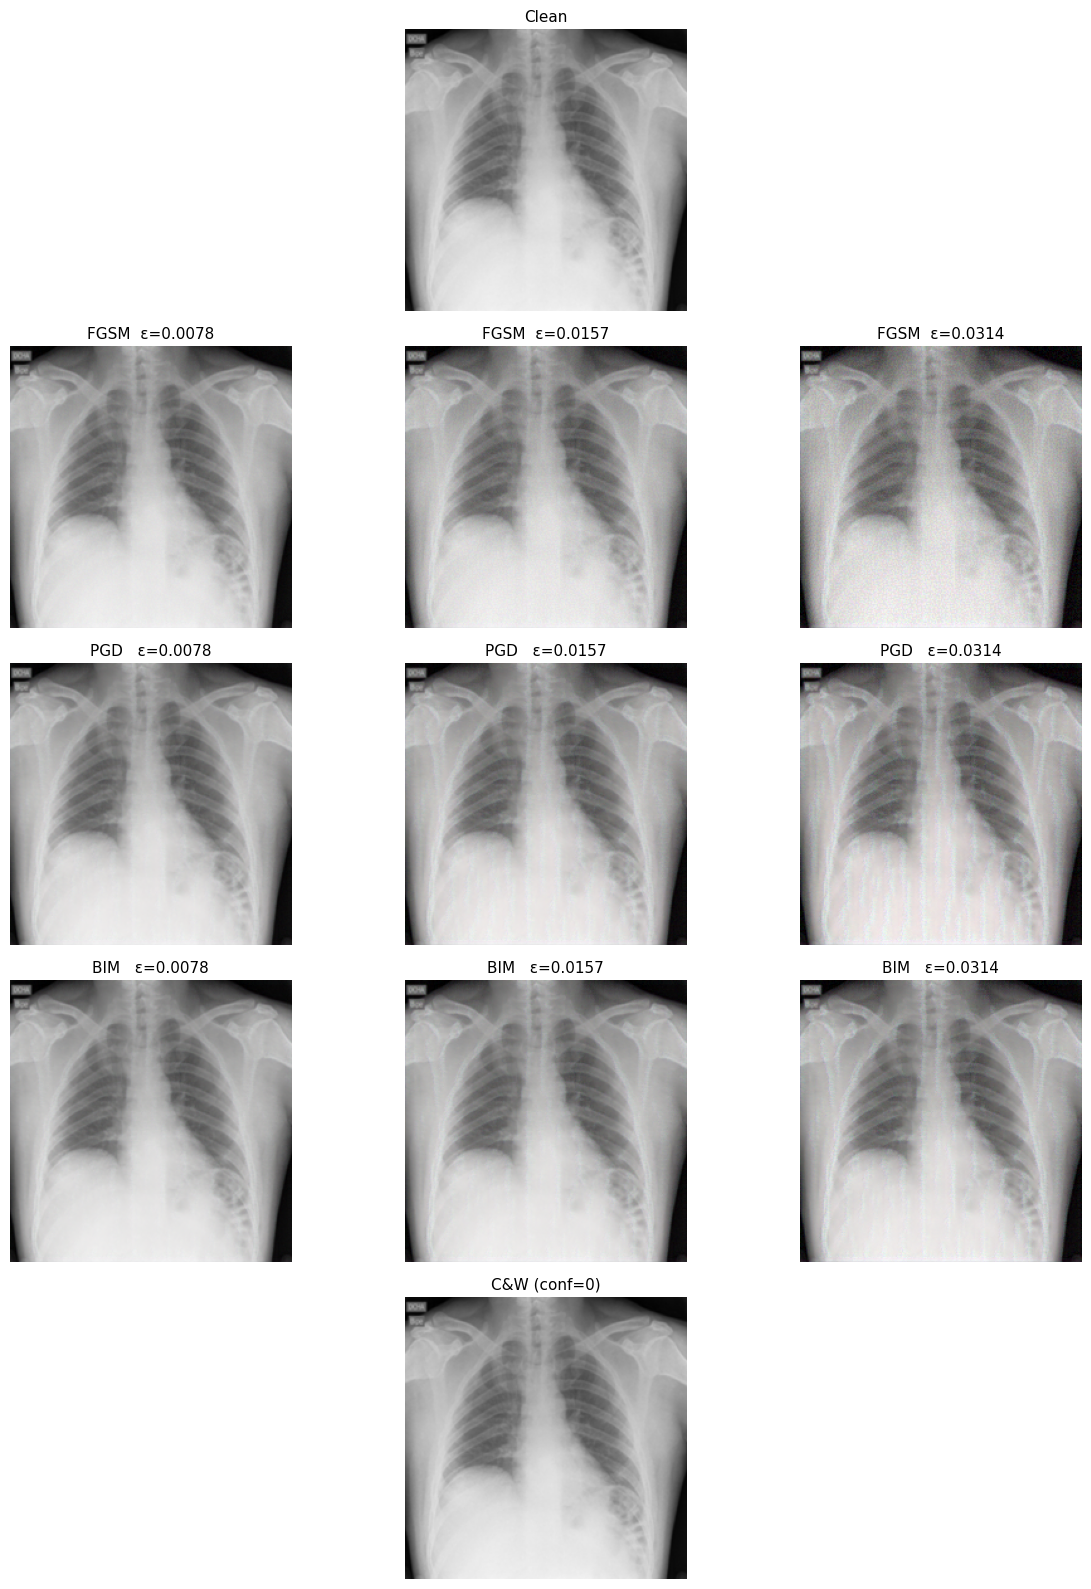

In [13]:
# === Visualisation : 1 Clean | 3 FGSM | 3 PGD | 3 BIM | 1 C&W ===
import numpy as np, torch, matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from art.attacks.evasion import (
    FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod, CarliniL2Method
)

model.eval()
EPS_LIST = [2/255, 4/255, 8/255]  

# 1) Choisir une image bien classée (fallback idx 0)
with torch.no_grad():
    xt = torch.from_numpy(X_test_np).to(DEVICE).float()
    xt = (xt - MEAN_T) / STD_T
    pred_all = model(xt).argmax(1).cpu().numpy()
good_idx = np.where(pred_all == y_test_np)[0]
idx_show = int(good_idx[0]) if len(good_idx) else 0

X_clean = X_test_np[idx_show:idx_show+1]  

# 2) Génération des adversaires (CPU)
# FGSM (batch_size=1)
fgsm_imgs = []
for eps in EPS_LIST:
    atk = FastGradientMethod(estimator=clf, eps=eps, batch_size=1)
    Xa = atk.generate(X_clean)  
    fgsm_imgs.append(Xa[0])

# PGD (eps_step=eps/8, iters=20, num_random_init=0)
pgd_imgs = []
for eps in EPS_LIST:
    atk = ProjectedGradientDescent(
        estimator=clf, eps=eps, eps_step=eps/8, max_iter=20,
        batch_size=1, targeted=False, num_random_init=0
    )
    Xa = atk.generate(X_clean)
    pgd_imgs.append(Xa[0])

# BIM (eps_step=eps/12, iters=12)
bim_imgs = []
for eps in EPS_LIST:
    atk = BasicIterativeMethod(estimator=clf, eps=eps, eps_step=eps/12, max_iter=12, batch_size=1)
    Xa = atk.generate(X_clean)
    bim_imgs.append(Xa[0])

# C&W (conf=0, max_iter=75, bsearch=1, lr=0.02, c0=0.3)
cw = CarliniL2Method(
    classifier=clf, targeted=False, confidence=0,
    max_iter=75, binary_search_steps=1, learning_rate=0.02,
    initial_const=0.3, batch_size=1
)
Xa_cw = cw.generate(X_clean)

# 3) Affichage (5 lignes × 3 colonnes ; Clean et C&W centrés en span)
fig = plt.figure(figsize=(12, 16))
gs = GridSpec(5, 3, figure=fig)

# Row 0 : Clean (span 3 colonnes)
ax = fig.add_subplot(gs[0, :])
ax.imshow(np.transpose(np.clip(X_clean[0], 0, 1), (1, 2, 0)))
ax.set_title("Clean", fontsize=11); ax.axis("off")

# Row 1 : FGSM (3 eps)
for j, eps in enumerate(EPS_LIST):
    ax = fig.add_subplot(gs[1, j])
    ax.imshow(np.transpose(np.clip(fgsm_imgs[j], 0, 1), (1, 2, 0)))
    ax.set_title(f"FGSM  ε={eps:.4f}", fontsize=11); ax.axis("off")

# Row 2 : PGD (3 eps)
for j, eps in enumerate(EPS_LIST):
    ax = fig.add_subplot(gs[2, j])
    ax.imshow(np.transpose(np.clip(pgd_imgs[j], 0, 1), (1, 2, 0)))
    ax.set_title(f"PGD   ε={eps:.4f}", fontsize=11); ax.axis("off")

# Row 3 : BIM (3 eps)
for j, eps in enumerate(EPS_LIST):
    ax = fig.add_subplot(gs[3, j])
    ax.imshow(np.transpose(np.clip(bim_imgs[j], 0, 1), (1, 2, 0)))
    ax.set_title(f"BIM   ε={eps:.4f}", fontsize=11); ax.axis("off")

# Row 4 : C&W (span 3 colonnes)
ax = fig.add_subplot(gs[4, :])
ax.imshow(np.transpose(np.clip(Xa_cw[0], 0, 1), (1, 2, 0)))
ax.set_title("C&W (conf=0)", fontsize=11); ax.axis("off")

plt.tight_layout(); plt.show()
